How does traveling affect a person's mobility variety?

In [203]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import geopy.distance
from sklearn.metrics.pairwise import cosine_similarity

In [13]:
checkin_index = ['UserID', 'VenueID', 'time', 'time_offset']
checkins = pd.read_csv("data/checkins_anonymized.txt", sep='\t', names = checkin_index)

In [14]:
friendship_index = ['UserID1', 'UserID2']
friendship_old = pd.read_csv("data/friendship_old.txt", sep='\t', names = friendship_index)
friendship_new = pd.read_csv("data/friendship_new.txt", sep='\t', names = friendship_index)

In [20]:
POI_index = ['VenueID', 'latitude', 'longitude', 'category', 'country'] #total 519 categories
POI = pd.read_csv("data/raw_POIs.txt", sep='\t', names = POS_index)

In [32]:
# First: influence of traveling, e.g. compute the cosine similarity between users who travel less/more

In [63]:
# Get a df of UserId lat lon

checkins_locations = checkins[['UserID','VenueID']]
locations_pos = POI[['VenueID', 'latitude', 'longitude']]
checkins_locations = checkins_locations.merge(locations_pos, left_on='VenueID', right_on='VenueID')

In [64]:
# Compute home for each user

user_homes = checkins_locations[['UserID','latitude','longitude']]
user_homes = checkins_locations.groupby('UserID').mean()

In [105]:
# Divide into bins according to distance to home

checkins_locations_distance = checkins_locations.merge(user_homes, left_on='UserID', right_on='UserID', suffixes=['_venue', '_home'])

In [ ]:
def home_distance(x):
    return geopy.distance.distance((x['latitude_venue'],x['longitude_venue']),(x['latitude_home'],x['longitude_home'])).km

checkins_locations_distance_c = checkins_locations_distance.sample(len(checkins_locations_distance)//20)
checkins_locations_distance_c.reset_index(drop=True)

checkins_locations_distance_c['home_distance'] = checkins_locations_distance_c.apply(home_distance, axis=1)

In [129]:
user_avg_home_distance = checkins_locations_distance_c[['UserID', 'home_distance']]
user_avg_home_distance = user_avg_home_distance.groupby('UserID').mean()

In [182]:
bins = np.logspace(0.1, 4.3,8)
bin_centers = 0.5*(bins[1:] + bins[:-1])

bin_data = []
for i in range(len(bin_centers)):
    index = (user_avg_home_distance['home_distance'] >= bins[i]) & (user_avg_home_distance['home_distance'] < bins[i+1])
    current_checkins = user_avg_home_distance[index]
    bin_data.append(current_checkins)

In [266]:
# Replace each user with their visit vector

venue_category = POI[['VenueID', 'category']]
user_checkin = checkins_locations_distance_c[['UserID', 'VenueID']]
user_category = user_checkin.merge(venue_category, left_on='VenueID', right_on='VenueID')
user_category = user_category[['UserID', 'category']]

categories = user_category['category'].unique()

In [ ]:
categories_idx = dict(zip(categories, range(len(categories))))

def user_to_locvector(x):
    location_vector = [0]*len(categories)
    user_categories = user_category[user_category['UserID'] == x]
    for category in user_categories['category']:
        location_vector[categories_idx[category]] += 1
    return location_vector
    
def users_to_locvector(x):
    print("new vec")
    return [user_to_locvector(user) for user in x]

bin_data_vectors = [list(data['home_distance'].index) for data in bin_data]

for i in range(len(bin_data_vectors)):
    for j in range(len(bin_data_vectors[i])):
        bin_data_vectors[i][j] = user_to_locvector(bin_data_vectors[i][j])

In [ ]:
# Compute cosine similarity within each bin
similarities = [cosine_similarity(bin).mean() for bin in bin_data_vectors]

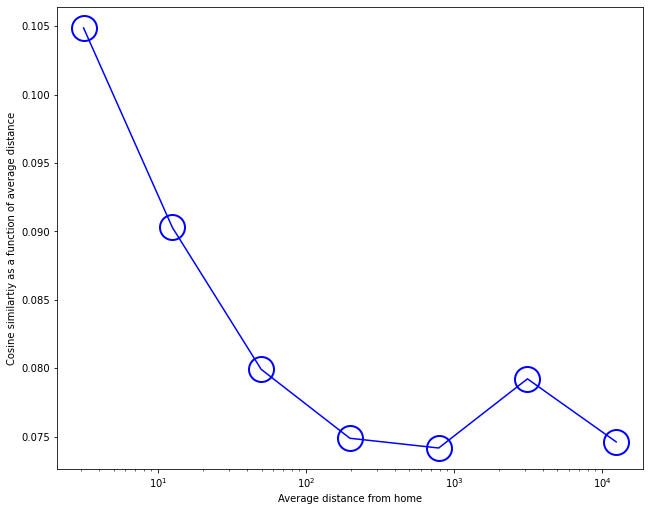

In [370]:
fig = plt.figure(figsize=(10.5, 8.5))
ax = fig.add_subplot(111)

plt.plot(bin_centers, similarities, 'b', markersize=25, marker='o', markeredgewidth=2, fillstyle='none')

# Use log axes
ax.set_xscale('log')
#ax.set_yscale('log')

# Set the labels and axes limits in order to get a result similar to the paper
plt.ylabel("Cosine similartiy as a function of average distance")
plt.xlabel("Average distance from home")


plt.show()

From the plot we can conclude that the more a person travels, the most "unique" it is, in the sense that their cosine similarity with people who travel approximatly as much is lower the more a person travels.

This can be explained by a few things: first of all traveling somewhat obligates a person to vary its visits: a Swiss person who travels a lot won't necessarly gain the occasion to eat fondue if she travels a lot! People traveling a lot won't necessarly travel in the same places so it explains that their visits are different from one another.

This explication seems satisfying but it cannot explain everything: indeed a group of people traveling an average of 50km will have a much lower similarity than a group who travels in average 5km (decrease of 20%) and show a clear difference as shown in the plot, even though the difference between both average distances is not that large (50km is still probably in the same city or in a neighbor one).

From this observation we could conclde that there is a clear correlation between a person's will to vary visits and discover new experiences, and its will to travel furthur (even though all needed amenities are present at a much closer distance).